# How does network structure lead to network dynamics?

Here, we look at examples where studying neural variability through time would help us undrestanding computations in the brain.  

We look at the neural response during the drifting gratings stimulus in neuropixel visual coding data set because of its long duration (2 seconds).

In [423]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import scipy.stats as stats
from drifting_gratings75 import DriftingGratings75

manifest_path = os.path.join("/home/koosha/Allen_data/", "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest = manifest_path)
sessions = cache.get_session_table()
session_ids = sessions.index.tolist()
session_id = session_ids[30] 
session = cache.get_session_data(session_id)

start_time = 0
end_time = 2000
time_step = 1
high_contrast = 1
direction = 0
area_name = "VISp"
min_range = 20
n_trials = 75
ds = DriftingGratings75(session_id)
conds_all = ds.getConditions()
conds_lh = ds.divideContrast(conds_all)
conds_contrast = conds_lh [high_contrast] 
conds_dir = ds.divideDirection(conds_contrast)  
conds = conds_dir[direction]
key_list = list(conds.keys())
n_trials = len(key_list)
spikes = ds.getSpikes(area_name, min_range)
data = ds.getData(spikes,conds, start_time, end_time, time_step)[:, :-2]
data_trial = data.reshape([n_trials, end_time - start_time, data.shape[-1]])
#trial_avg_fr = np.sum(data_trial, axis = 1) / ((end_time - start_time) / 1000)
#### picking the cherries:
sorted_inds = np.argsort(np.mean(trial_avg_fr, axis = 0))
example_neurons = [sorted_inds[-9], sorted_inds[-5], sorted_inds[-3]] 
v, v_times = ds.getVelocity()
trial_speed = np.zeros(n_trials)
for ci, cond in enumerate(key_list):
    trial_speed[ci] = np.mean(v[cond])
running_trials = np.where(trial_speed > 1)[0]
stat_trials = np.where(trial_speed <= 1)[0]

/home/koosha/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
/home/koosha/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


First, lets visualize the acitivity of some example neurons during the stiumlus averaged over all (75) repeated tirals for a given orientation (0 degree) and contrast (high).

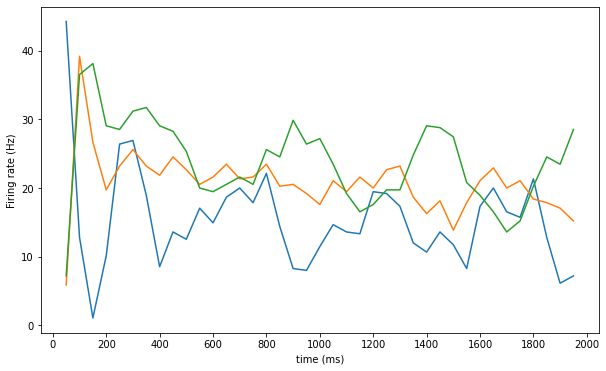

In [424]:
fr_window = 50
fr_slide = 50
num_window = ((end_time - start_time) - fr_window) // fr_slide 
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window, fr_slide):
    fr_binned[:, st_window // fr_slide, :] = (1000 / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)

plt.figure(figsize=(10,6))


for n in example_neurons:
    plt.plot(np.arange(start_time + fr_window, end_time, fr_slide), np.mean(fr_binned[:, :, n], axis = 0))
plt.xlabel('time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.xticks(np.arange(start_time, end_time - start_time + 1, (end_time - start_time) // 10));

Does the activity follow a poisson process in each trail? We can look at the Fano factor for that. 

# Fano factor

Text(0, 0.5, 'Num trials')

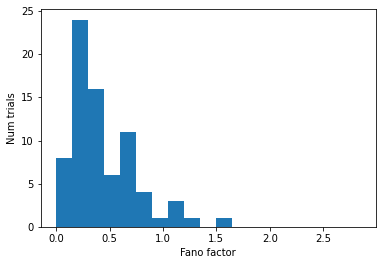

In [425]:
#####TODO:read spike times directly
mean_isis = np.zeros([n_trials, data.shape[-1]])
for n in range(data.shape[-1]):
    #n = example_neurons[n_ind]
    for tr in range(n_trials):
        spike_times = np.where(data_trial[tr, :, n] > 0)[0]
        if spike_times.size > 2:
            mean_isis[tr, n] = np.mean(np.diff(spike_times))

fr_window = 200
fr_slide = 200
num_window = 1 + (((end_time - start_time) - fr_window) // fr_slide)
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window + 1, fr_slide):
    fr_binned[:, st_window // fr_slide, :] =  (mean_isis / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)

response_means = np.mean(fr_binned[:, 4:], axis = 1)
response_vars = np.var(fr_binned[:, 4:], axis = 1)
fano = response_vars / (response_means + 10 ** -40)

plt.hist(fano[:, example_neurons[0]], bins = np.arange(0, 3, .15))
plt.xlabel("Fano factor")
plt.ylabel("Num trials")

The fano factor is less than 1 for almost all of the neurons. While this suggests less variabilty than expcted it has been shown before by Kara, Reinagel, and Reid (Neuron 2000). 

# Excersie: Check the variability in other cortical and sub-cortical regions. Compare the results with the Kara et al results. 

# Variability Over trials

First, let's look at the distribuation of firing rate (measured during the whole 2 seconds of each trial) over the 75 repeats for our three example neurons. 

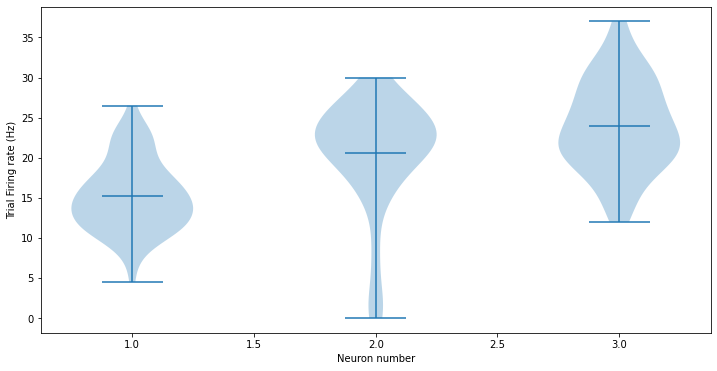

In [426]:
plt.figure(figsize=(12,6))
plt.violinplot(np.sum(data_trial / 2, axis = 1)[:, example_neurons], showmeans = True)
plt.ylabel("Trial Firing rate (Hz)")
plt.xlabel("Neuron number");

# TODO: Fano factor over trials.

# Over trials for running and stationary

One source of variability is animal's internal state which also affects neural responses in the visual cortex. 

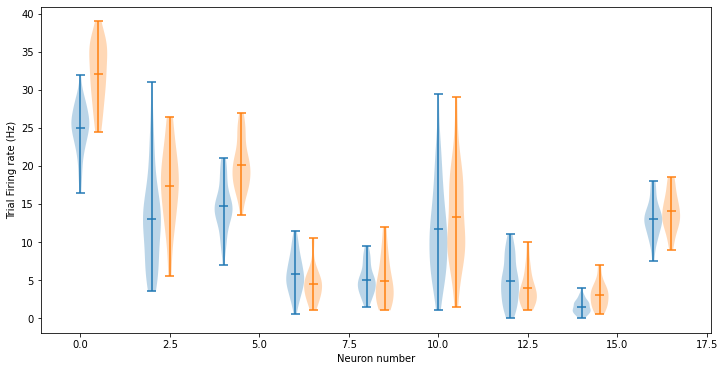

In [427]:
sc_trial = np.sum(data_trial, axis = 1) / 2
more_example_neurons = [sorted_inds[-13], sorted_inds[-9], sorted_inds[-7], sorted_inds[-11], sorted_inds[-5], sorted_inds[-3]] 
more_example_neurons = range(0, data.shape[-1], 6)
stat_pos = 2 * np.arange(len(more_example_neurons))
plt.figure(figsize=(12,6))
plt.violinplot(sc_trial[:, more_example_neurons][stat_trials], positions= stat_pos, showmeans = True)
plt.violinplot(sc_trial[:, more_example_neurons][running_trials], positions= stat_pos + .5, showmeans = True)
plt.ylabel("Trial Firing rate (Hz)")
plt.xlabel("Neuron number");

# Average population response over time 

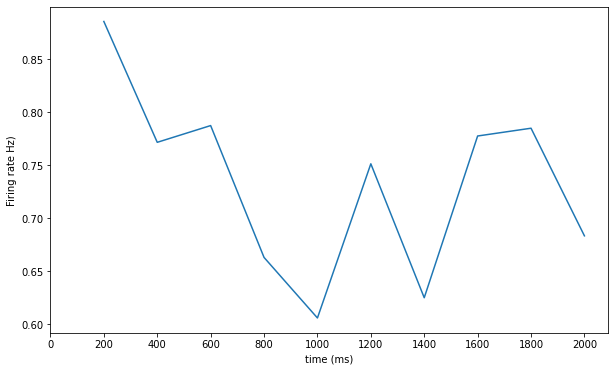

In [428]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(start_time + fr_window, end_time + 1, fr_slide), np.mean(np.mean(fr_binned, axis = 0), axis = -1))
plt.xlabel('time (ms)')
plt.ylabel('Firing rate Hz)')
plt.xticks(np.arange(start_time, end_time - start_time + 1, (end_time - start_time) // 10));

# Encoding based on direction and contrast

In [429]:
key_list = list(conds_all.keys())
n_trials = len(key_list)
data = ds.getData(spikes, conds_all, start_time, end_time, time_step)[:, :-2]
data_trial = data.reshape([n_trials, (end_time - start_time), data.shape[-1]])
cond_matrix = np.zeros([n_trials, 2], dtype = int)
for c, cond_id in enumerate(key_list):
    cond_matrix[c, :] = conds_all[cond_id]


trial_speed = np.zeros(n_trials)
for ci, cond in enumerate(key_list):
    trial_speed[ci] = np.mean(v[cond])
running_trials = np.where(trial_speed > 1)[0]
stat_trials = np.where(trial_speed <= 1)[0]
    
    
fr_window = 200
fr_slide = 200
num_window = 1 + (((end_time - start_time) - fr_window) // fr_slide)
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window + 1, fr_slide):
    fr_binned[:, st_window // fr_slide, :] =  (1000 / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)


let's look at the time bin of 1200 to 1400 ms after stimulus-onset.

Text(0, 0.5, 'Num Neurons')

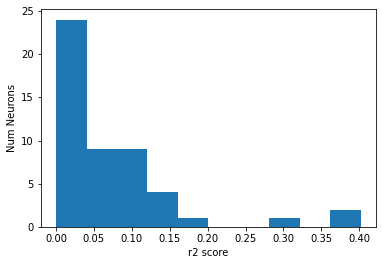

In [430]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
features = np.hstack([cond_matrix, trial_speed.reshape(-1, 1)])
model = LinearRegression()
Y = fr_binned[:, 6, :] 
X = features
model.fit(X, Y)
y_pred = model.predict(X)
all_r2s = r2_score(Y, y_pred, multioutput = 'raw_values' )
plt.hist(all_r2s)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons")


Now let's add the neural response in the previous time bin (1000 to 1200). to our model  

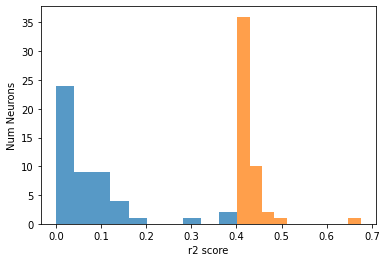

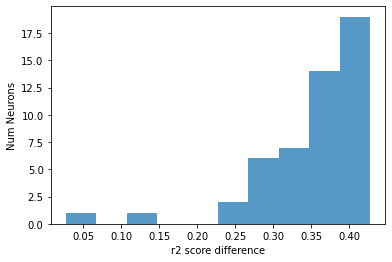

In [431]:
all_r2s_prev= np.zeros(data.shape[-1])
for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, fr_binned[:, 4, n:n+1]])
    model.fit(X2, Y)
    y_pred = model.predict(X2)
    all_r2s_prev[n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");


# Is it because of the dynamics? or just the other factor during the trial? 

# Let's check how the first bin predict.

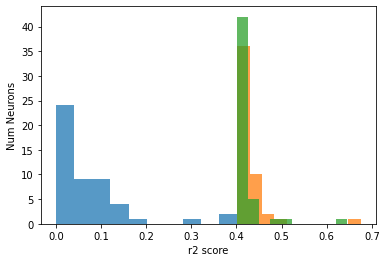

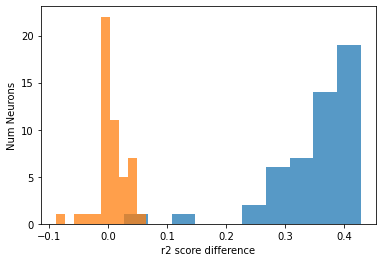

In [432]:
all_r2s_first= np.zeros(data.shape[-1])
for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, fr_binned[:, 0, n:n+1]])
    model.fit(X2, Y)
    y_pred = model.predict(X2)
    all_r2s_first[n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_first, alpha = .75)

plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.hist(all_r2s_prev - all_r2s_first, alpha = .75)

plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");

What if we use the shuffled data? (excluding 1000-1600 ms) 

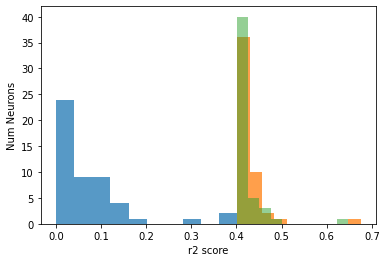

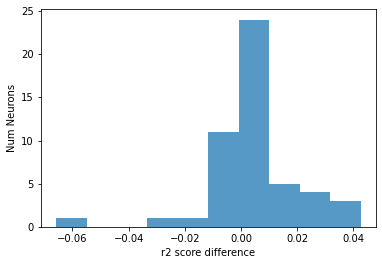

In [433]:
data_trial_other_windows = np.delete(data_trial, np.arange(1000, 1600), axis = 1)
order = np.arange(data_trial_other_windows.shape[1])
np.random.shuffle(order)
random_fr_binned = (1000 / fr_window) * np.sum(data_trial_other_windows[:, order[:fr_window], :], axis = 1)
all_r2s_rand = np.zeros(data.shape[-1])

for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, random_fr_binned[:, n:n+1]])
    model.fit(X2, Y)
    y_pred = model.predict(X2)
    all_r2s_rand[n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_rand, alpha = .5)

plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.show()
plt.hist(all_r2s_prev - all_r2s_rand, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");



more shuffles:

In [435]:
num_tests = 200
all_r2s_rand = np.zeros([num_tests, data.shape[-1]])
all_random_fr_binned = np.zeros([num_tests] + list(random_fr_binned.shape))
data_trial_other_windows = np.delete(data_trial, np.arange(1000, 1600), axis = 1)
order = np.arange(data_trial_other_windows.shape[1])
for i in range(num_tests):
    np.random.shuffle(order)
    all_random_fr_binned[i] = (1000 / fr_window) * np.sum(data_trial_other_windows[:, order[:fr_window], :], axis = 1)
    for n in range(fr_binned.shape[-1]):
        X2 = np.hstack([features, all_random_fr_binned[i, :, n:n+1]])
        model.fit(X2, Y)
        y_pred = model.predict(X2)
        all_r2s_rand[i, n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]

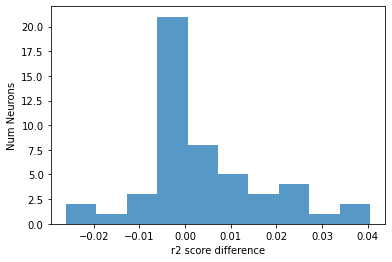

In [436]:
import scipy
#### difference with mean 
all_r2s_rand_mean = np.mean(all_r2s_rand, axis = 0)
plt.hist(all_r2s_prev - all_r2s_rand_mean, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons")
plt.show()

In [439]:
sig_neurons = []
for n in range(data.shape[-1]):
    if np.quantile(all_r2s_prev[n] - all_r2s_rand[:, n], .05) > 0:
        sig_neurons.append(n)

sig_neurons, all_r2s_prev[sig_neurons] - all_r2s_rand_mean[sig_neurons] 

([4, 6, 9, 12, 15, 20, 21, 26, 30, 31, 32, 33, 36, 37, 40, 41],
 array([0.00953365, 0.04051691, 0.03109322, 0.01644175, 0.03571519,
        0.02308979, 0.01043947, 0.01414101, 0.00453757, 0.02114789,
        0.02705758, 0.01359249, 0.01012764, 0.00665454, 0.02436843,
        0.01877907]))

What if we look at this for 1 specific condition (e.g. 0 degree and high contrast)?

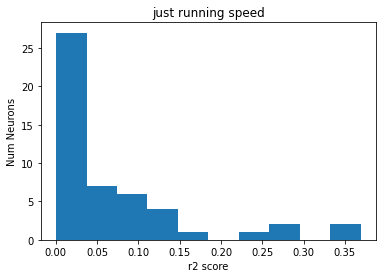

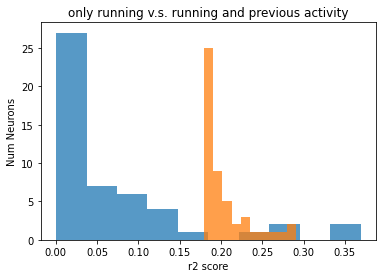

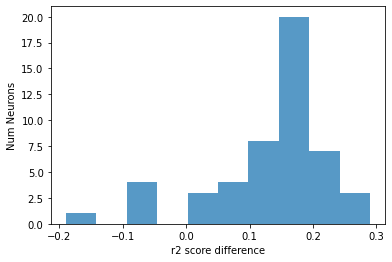

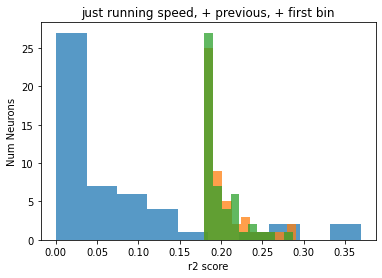

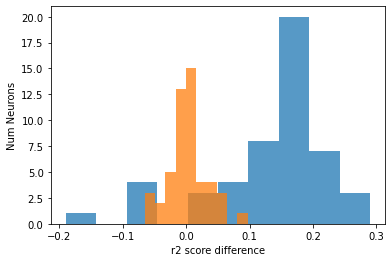

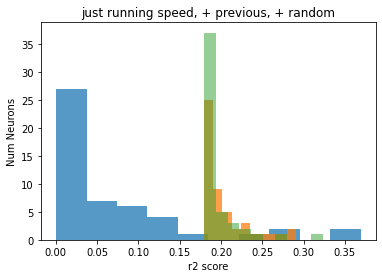

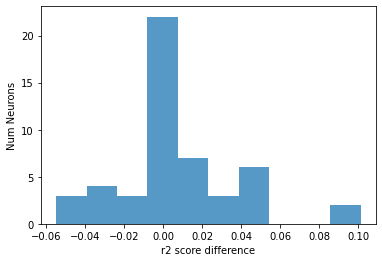

In [440]:
key_list = conds
n_trials = len(key_list)
data = ds.getData(spikes, conds, start_time, end_time, time_step)[:, :-2]
data_trial = data.reshape([n_trials, (end_time - start_time), data.shape[-1]])
cond_matrix = np.zeros([n_trials, 2], dtype = int)
for c, cond_id in enumerate(key_list):
    cond_matrix[c, :] = conds_all[cond_id]


trial_speed = np.zeros(n_trials)
for ci, cond in enumerate(key_list):
    trial_speed[ci] = np.mean(v[cond])
running_trials = np.where(trial_speed > 1)[0]
stat_trials = np.where(trial_speed <= 1)[0]
    
    
fr_window = 200
fr_slide = 200
num_window = 1 + (((end_time - start_time) - fr_window) // fr_slide)
fr_binned = np.zeros([data_trial.shape[0], num_window, data.shape[-1]])
for st_window in range(0, end_time - start_time - fr_window + 1, fr_slide):
    fr_binned[:, st_window // fr_slide, :] =  (1000 / fr_window) * np.sum(data_trial[:, st_window : st_window + fr_window, :], axis = 1)

features = np.hstack([cond_matrix, trial_speed.reshape(-1, 1)])
model = LinearRegression()
Y = fr_binned[:, 6, :] 
X = features
model.fit(X, Y)
y_pred = model.predict(X)
all_r2s = r2_score(Y, y_pred, multioutput = 'raw_values' )
plt.hist(all_r2s)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.title("just running speed")
plt.show()

all_r2s_prev= np.zeros(data.shape[-1])
for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, fr_binned[:, 4, n:n+1]])
    model.fit(X2, Y)
    y_pred = model.predict(X2)
    all_r2s_prev[n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.title("only running v.s. running and previous activity")
plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");
plt.show()

all_r2s_first= np.zeros(data.shape[-1])
for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, fr_binned[:, 0, n:n+1]])
    model.fit(X2, Y)
    y_pred = model.predict(X2)
    all_r2s_first[n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]
plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_first, alpha = .75)

plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.title("just running speed, + previous, + first bin")

plt.show()
plt.hist(all_r2s_prev - all_r2s, alpha = .75)
plt.hist(all_r2s_prev - all_r2s_first, alpha = .75)

plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");
plt.show()

data_trial_other_windows = np.delete(data_trial, np.arange(1000, 1600), axis = 1)
order = np.arange(data_trial_other_windows.shape[1])
np.random.shuffle(order)
random_fr_binned = (1000 / fr_window) * np.sum(data_trial_other_windows[:, order[:fr_window], :], axis = 1)
all_r2s_rand = np.zeros(data.shape[-1])

for n in range(fr_binned.shape[-1]):
    X2 = np.hstack([features, random_fr_binned[:, n:n+1]])
    model.fit(X2, Y)
    y_pred = model.predict(X2)
    all_r2s_rand[n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]

plt.hist(all_r2s, alpha = .75)
plt.hist(all_r2s_prev, alpha = .75)
plt.hist(all_r2s_rand, alpha = .5)
plt.xlabel("r2 score")
plt.ylabel("Num Neurons")
plt.title("just running speed, + previous, + random")

plt.show()
plt.hist(all_r2s_prev - all_r2s_rand, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons");


Let's make our observation more accurate by trying the shuffle many times 

In [441]:
num_tests = 500
all_r2s_rand = np.zeros([num_tests, data.shape[-1]])
all_random_fr_binned = np.zeros([num_tests] + list(random_fr_binned.shape))
data_trial_other_windows = np.delete(data_trial, np.arange(1000, 1600), axis = 1)
order = np.arange(data_trial_other_windows.shape[1])
for i in range(num_tests):
    np.random.shuffle(order)
    all_random_fr_binned[i] = (1000 / fr_window) * np.sum(data_trial_other_windows[:, order[:fr_window], :], axis = 1)
    for n in range(fr_binned.shape[-1]):
        X2 = np.hstack([features, all_random_fr_binned[i, :, n:n+1]])
        model.fit(X2, Y)
        y_pred = model.predict(X2)
        all_r2s_rand[i, n] = r2_score(Y, y_pred, multioutput = 'raw_values')[0]

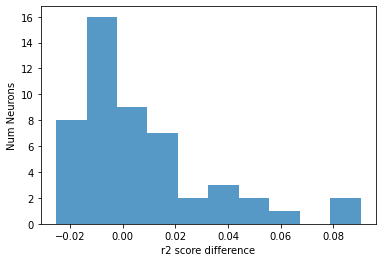

In [442]:
import scipy
#### difference with mean 
all_r2s_rand_mean = np.mean(all_r2s_rand, axis = 0)
plt.hist(all_r2s_prev - all_r2s_rand_mean, alpha = .75)
plt.xlabel("r2 score difference")
plt.ylabel("Num Neurons")
plt.show()

In [445]:
sig_neurons = []
for n in range(data.shape[-1]):
    if np.quantile(all_r2s_prev[n] - all_r2s_rand[:, n], .05) > 0:
        sig_neurons.append(n)
sig_neurons, all_r2s_prev[sig_neurons] - all_r2s_rand_mean[sig_neurons] 

([2, 3, 4, 6, 15, 34, 36, 39, 49],
 array([0.03535006, 0.06439936, 0.03162718, 0.03638101, 0.04475196,
        0.08920995, 0.04352042, 0.09033489, 0.05293133]))

Discussion: 
    1- What is the difference here? Why?
    2- What are the potential issues in our analysis?

# TODO: Decoding approach